## Ships in Satellite Imagery

### Context:

Detecting the location of large ships in satellite images.

### Content:

This dataset is from Planet satellite imagery which collected over the San Francisco Bay and San Pedro Bay areas of California. It includes 4000 80x80 RGB images labeled with either a "ship" or "no-ship" classification.

label: Valued 1 representing the "ship" class, valued 0 representing the "no-ship" class.

scene id: The unique identifier of the PlanetScope visual scene the image chip was extracted from. The scene id can be used with the Planet API to discover and download the entire scene.

longitude_latitude: The longitude and latitude coordinates of the image center point, with values separated by a single underscore.

80x80 RGB image is stored as a list of 19200 integers. The first 6400 entries includes the red channel values, the next 6400 is green, third 6400 is blue. 

# Data Wrangling and EDA

In [1]:
#Import the necessary modules

import json
import matplotlib.pyplot as plt
from skimage import color
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import InputLayer
from keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten, Activation

Using TensorFlow backend.


In [2]:
#Check for the feaures
df = pd.read_json('C://Users//kurt_//Downloads//shipsnet.json//shipsnet.json')
df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [4]:
#Load the dataset
f = open('C://Users//kurt_//Downloads//shipsnet.json//shipsnet.json')
dataset = json.load(f)
f.close()

In [5]:
#Convert datas from list to array
data_ = np.array(dataset['data']).astype('uint8')
labels_ = np.array(dataset['labels']).astype('uint8')

#It will be seen from the shape that data includes 4000 images and every image represented as a vector of length 19200 elements.
print(data_.shape)
print(labels_.shape)

(4000, 19200)
(4000,)


In [6]:
#Check for NULL values in data and labels
print(np.isnan(data_).sum())
print(np.isnan(labels_).sum())

0
0


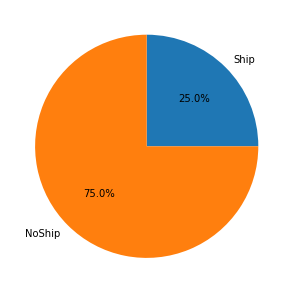

Number of ship: 1000
Number of no-ship: 3000


In [7]:
#Check for ship/no-ship numbers 
number_ship = np.sum(labels_==1)
number_noship = np.sum(labels_==0)

sizes = [number_ship, number_noship]
titles = "Ship", "NoShip"

fig = plt.figure(figsize=(5, 7))
plt.pie(sizes, labels=titles, autopct='%1.1f%%')
plt.show() 

print('Number of ship:', number_ship)
print('Number of no-ship:', number_noship)

In [8]:
#Color channel 3:RGB
n_spct = 3
w = 80
h = 80
data_ = data_.reshape([-1, n_spct, w, h])

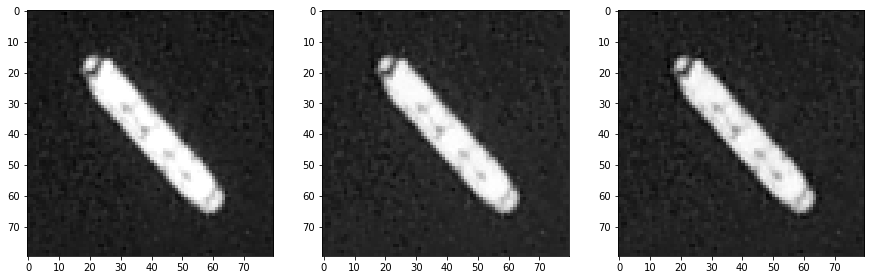

In [9]:
#Get one channel
pic = data_[0]

red_spct = pic[0]
green_spct = pic[1]
blue_spct = pic[2]

#Plot each channel
plt.figure(figsize=(15, 5))
plt.set_cmap('gray')

plt.subplot(1, 3, 1)
plt.imshow(red_spct)

plt.subplot(1, 3, 2)
plt.imshow(green_spct)

plt.subplot(1, 3, 3)
plt.imshow(blue_spct)

plt.show()

In [10]:
#Check for shapes
print(data_.shape)
print(labels_.shape)

(4000, 3, 80, 80)
(4000,)


# Pre-Processing

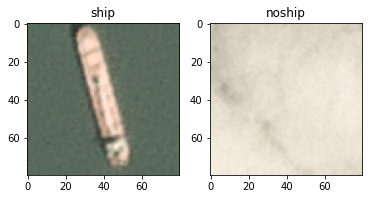

In [11]:
#Reshape the data
data = data_.transpose([0, 2, 3, 1])
ship = data[labels_==1]
noship = data[labels_==0]

def plot_(x, y):
    
    plt.figure(figsize=(6, 8))

    plt.subplot(1, 2, 1)
    plt.title('ship')
    plt.imshow(x[100])

    plt.subplot(1, 2, 2)
    plt.title('noship')
    plt.imshow(y[100])

    plt.show()

plot_(ship, noship)

In [12]:
#Scale the images by 255.0 to convert RGB pixel values to floats
data = data / 255.0

In [13]:
#One hot encoding for labels
labels = np_utils.to_categorical(labels_, 2)
print(labels.shape)

(4000, 2)


# Modeling

In [31]:
#Create sequential model
model = Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) 
model.add(keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [32]:
#Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
#Train the model
model_result = model.fit(data, labels, batch_size=32, epochs=20, 
                         validation_split=0.2, verbose=2)

Epoch 1/20
100/100 - 23s - loss: 0.3277 - accuracy: 0.8756 - val_loss: 0.7785 - val_accuracy: 0.5400
Epoch 2/20
100/100 - 23s - loss: 0.1689 - accuracy: 0.9347 - val_loss: 0.1903 - val_accuracy: 0.9100
Epoch 3/20
100/100 - 22s - loss: 0.1320 - accuracy: 0.9494 - val_loss: 0.3384 - val_accuracy: 0.8388
Epoch 4/20
100/100 - 21s - loss: 0.0814 - accuracy: 0.9700 - val_loss: 0.2647 - val_accuracy: 0.8825
Epoch 5/20
100/100 - 22s - loss: 0.0525 - accuracy: 0.9800 - val_loss: 0.4033 - val_accuracy: 0.8175
Epoch 6/20
100/100 - 22s - loss: 0.0380 - accuracy: 0.9859 - val_loss: 0.4334 - val_accuracy: 0.8138
Epoch 7/20
100/100 - 23s - loss: 0.0368 - accuracy: 0.9919 - val_loss: 0.2185 - val_accuracy: 0.9025
Epoch 8/20
100/100 - 24s - loss: 0.0175 - accuracy: 0.9931 - val_loss: 0.2899 - val_accuracy: 0.8838
Epoch 9/20
100/100 - 23s - loss: 0.0142 - accuracy: 0.9937 - val_loss: 0.2816 - val_accuracy: 0.8875
Epoch 10/20
100/100 - 24s - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.2092 - val_accura

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)            

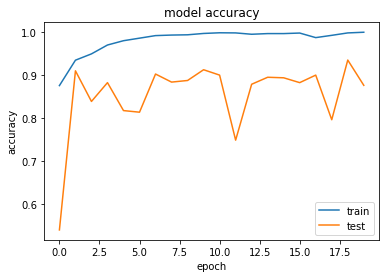

In [35]:
#Summarize history for accuracy
plt.plot(model_result.history['accuracy'])
plt.plot(model_result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

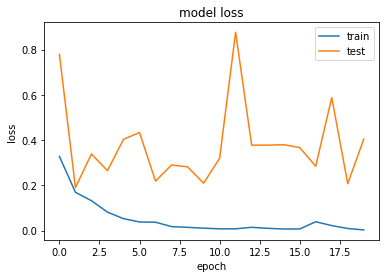

In [36]:
plt.plot(model_result.history['loss'])
plt.plot(model_result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [37]:
model.evaluate(data, labels)

125/125 [==============================] - 6s 47ms/step - loss: 0.0830 - accuracy: 0.9750


[0.08299419283866882, 0.9750000238418579]